In [1]:
import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.models.resnet import ResNet50_Weights
import lightning.pytorch as pl
from ultralytics import YOLO

from mymodels import Model_Wrapper, Preprocess
from myutils import View, sample_imgs_list, compare_ds

In [2]:
# configs to speed up training
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
# model = YOLO('yolov8s.pt', )  # get pretrained model
# model = Model_Wrapper(model, type='yolo')  # wrap model to use with lightning
# trainer = pl.Trainer(accelerator='auto', limit_test_batches=3)

In [4]:
PATH_TO_COCO = '/f_storage/datasets/coco/2017'
NUM_IMG_EVAL = 10000
prep = Preprocess(PATH_TO_COCO, (640, 640), dataset_type='coco', shuffle=False, batch_size=32)
preview_img_slice = slice(00000, 50000, 10000)
%matplotlib inline

In [5]:
# prep.reset_trans()
# coco = prep.get_dataset()

# from yolo_wrapper import YOLOv8_COCO_Wrapper
# from coco_ds import CocoDataset, CocoResults

# model = YOLOv8_COCO_Wrapper(CocoResults(coco), 'yolov8s.pt')

# id, img, size = coco[1]

# evaluator, plot = model.predict_coco(id, img*255, size, gen_plot=True)
# metrics = evaluator.eval()

# print(f'Confidence: {metrics["conf"]:.2f}')
# print(f'mAP: {metrics["AP"]:.2f}')

# View.compare_color(plot)


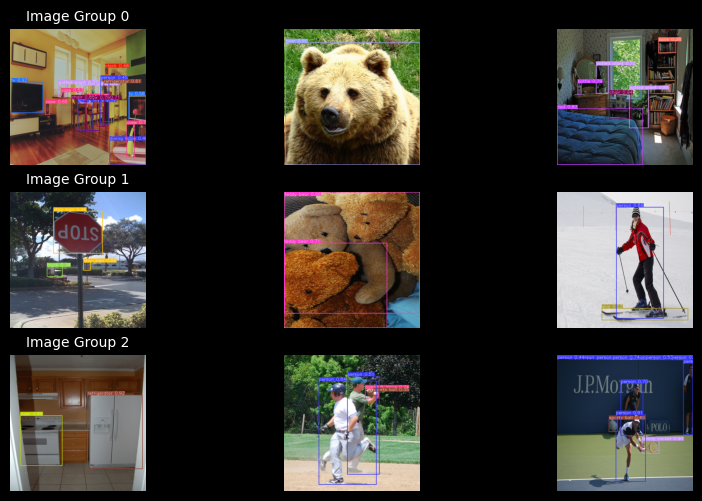

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     60.52373123168945     │
│      Pixel Val MEAN       │    112.38577270507812     │
│       Pixel Val STD       │     70.99114227294922     │
│        mAP 50:95 %        │    2.3007336641732428     │
└───────────────────────────┴───────────────────────────┘

[{'mAP 50:95 %': 2.3007336641732428,
  'Confidence %': 60.52373123168945,
  'Pixel Val STD': 70.99114227294922,
  'Pixel Val MEAN': 112.38577270507812}]

In [7]:
from yolo_wrapper import YOLOv8_COCO_Wrapper
from coco_ds import CocoDataset, CocoResults


import logging
logging.disable(logging.INFO)

prep.reset_trans()
coco = prep.get_loader()

model = YOLOv8_COCO_Wrapper(CocoResults(coco.dataset), 'yolov8s.pt')


id, img, size = next(iter(coco))
_, plot = model.predict_coco(id, img, size, gen_plot=True)

View.compare_color([plot[0:3], plot[3:6], plot[6:9]])
    


l_model = Model_Wrapper(model, model_type='yolo')
trainer = pl.Trainer(accelerator='auto', limit_test_batches=100)
trainer = pl.Trainer(accelerator='auto')

trainer.test(l_model, coco)

In [ ]:
# import numpy as np
# from copy import deepcopy

# results = model(img.unsqueeze(0)*255)

# res_plot = deepcopy(results[0])
# res_plot.orig_img = np.ascontiguousarray(img.permute(1, 2, 0).cpu().numpy() *255).astype(np.uint8)
# plot = res_plot.plot()
# View.compare_color(plot)

In [ ]:
from coco_ds import CocoResults

# results[0].orig_shape = torch.Tensor(size)
# results[0].update()
# results[0].boxes.orig_shape = torch.Tensor(size)
# print(results[0].orig_shape)

print(results[0].boxes)

bboxes = results[0].boxes.xywh[0].cpu().tolist()
score = results[0].boxes[0].conf.cpu().item()
label = int(results[0].boxes[0].cls.cpu().item())

bboxes[0] *= size[1] / 640
bboxes[1] *= size[0] / 640
bboxes[2] *= size[1] / 640
bboxes[3] *= size[0] / 640

result = [label, bboxes, score]

print(result)

coco_results = CocoResults(coco).add_results([result], id)
# print(coco_results.coco_results)
mAP = coco_results.eval()
print(f'mAP: {mAP}')

In [ ]:
# prep.reset_trans()
# imgnet_orig = prep.get_loader()
# sample_orig = sample_imgs_list(imgnet_orig, preview_img_slice)# test model on original images
# result_orig = trainer.test(model, imgnet_orig)